# 01_eda.ipynb
## Project - Spotify 2023
# Goal: First look at the dataset (ingestion + quick overview)

## Load dataset

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

RAW_PATH = Path("../data/raw/spotify-2023.csv")
assert RAW_PATH.exists(), f"File not found: {RAW_PATH.resolve()}"

try:
    df = pd.read_csv(
        RAW_PATH,
        sep=",",
        encoding="utf-8",
        low_memory=False,
        dtype={
            "streams": "string",
            "in_deezer_playlists": "string",
            "in_shazam_charts": "string"
        }
    )
except UnicodeDecodeError:
    df = pd.read_csv(
        RAW_PATH,
        sep=",",
        encoding="latin1",
        low_memory=False,
        dtype={
            "streams": "string",
            "in_deezer_playlists": "string",
            "in_shazam_charts": "string"
        }
    )

# Verifica struttura minima (coerente con cleaning successivo)
expected_cols = {
    "streams", "in_deezer_playlists", "in_shazam_charts",
    "track_name", "artist(s)_name", "bpm", "key", "mode"
}
missing = expected_cols - set(df.columns)
assert not missing, f"Missing expected columns: {missing}"

print("Loaded:", RAW_PATH)
print("Shape:", df.shape)
display(df.head(3))

Loaded: ..\data\raw\spotify-2023.csv
Shape: (953, 24)


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6


## Missing values, duplicates and dtypes overview

In [5]:
missing = df.isnull().sum().sort_values(ascending=False)
duplicates = df.duplicated().sum()
dtypes = df.dtypes

display(missing.head(20)), 
print(f"number of duplicates row: {duplicates}")
display(dtypes)

key                     95
in_shazam_charts        50
track_name               0
artist(s)_name           0
released_month           0
released_day             0
artist_count             0
released_year            0
in_spotify_charts        0
in_spotify_playlists     0
streams                  0
in_apple_playlists       0
in_deezer_playlists      0
in_apple_charts          0
in_deezer_charts         0
bpm                      0
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
dtype: int64

number of duplicates row: 0


track_name                      object
artist(s)_name                  object
artist_count                     int64
released_year                    int64
released_month                   int64
released_day                     int64
in_spotify_playlists             int64
in_spotify_charts                int64
streams                 string[python]
in_apple_playlists               int64
in_apple_charts                  int64
in_deezer_playlists     string[python]
in_deezer_charts                 int64
in_shazam_charts        string[python]
bpm                              int64
key                             object
mode                            object
danceability_%                   int64
valence_%                        int64
energy_%                         int64
acousticness_%                   int64
instrumentalness_%               int64
liveness_%                       int64
speechiness_%                    int64
dtype: object

## Clean numeric columns stored as strings and handle missing values

### Remove non-numeric rows from 'streams'

In [7]:

# 1) Basic info
print("dtype:", df["streams"].dtype)
print("shape:", df.shape)

# 2) Show raw sample (repr to reveal hidden chars)
raw_sample = df["streams"].head(10).apply(repr).tolist()
print("\nRaw sample (repr):")
for r in raw_sample:
    print("  ", r)

# 3) Columns sanity check (exact names)
print("\nColumns:", list(df.columns))

# 4) Detect rows with letters in `streams` (e.g., 'BPM', 'Key', 'Mode', etc.)
s_str = df["streams"]
bad_alpha = s_str[s_str.str.contains(r"[A-Za-z]", na=False)].head(10)
print("\nRows with alphabetic chars in `streams` (first 10):")
for r in bad_alpha.tolist():
    print("  ", r)

# 5) Character inventory: which non-numeric chars appear?
chars = set("".join(s_str.dropna().tolist()))
non_numeric_chars = sorted([c for c in chars if c not in set("0123456789")])
print("\nNon-numeric characters present in `streams`:", non_numeric_chars)

# 6) Check how many become numeric after removing common separators/spaces (comma, dot, space, NBSP)
s_clean_basic = (
    s_str
    .str.replace(",", "", regex=False)
    .str.replace(".", "", regex=False)
    .str.replace("\u00A0", "", regex=False)   # NBSP
    .str.replace(" ", "", regex=False)
)
prop_numeric_basic = s_clean_basic.str.isnumeric().mean(skipna=True)

print(f"\nProportion numeric after removing commas/dots/spaces: {prop_numeric_basic:.3f}")

# 7) Show a few values that still fail numeric after basic cleaning
bad_after_basic = s_str.loc[~s_clean_basic.str.isnumeric()].head(10)
print("\nStill non-numeric after basic cleaning (first 10):")
for r in bad_after_basic.tolist():
    print("  ", r)


dtype: string
shape: (953, 24)

Raw sample (repr):
   '141381703'
   '133716286'
   '140003974'
   '800840817'
   '303236322'
   '183706234'
   '725980112'
   '58149378'
   '95217315'
   '553634067'

Columns: ['track_name', 'artist(s)_name', 'artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists', 'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm', 'key', 'mode', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']

Rows with alphabetic chars in `streams` (first 10):
   BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3

Non-numeric characters present in `streams`: ['A', 'B', 'D', 'E', 'I', 'K', 'L', 'M', 'P', 'S', 'V', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y']

Proportion numeric after removing

## clean numeric columns 
the dataset has some issues in `streams`, `in_deezer_playlists`, and `in_shazam_charts`:
- `streams` sometimes includes commas, dots, or corrupted strings (e.g., BPM info).
- `in_deezer_playlists` and `in_shazam_charts` may contain missing or non-numeric values.

In [9]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()

    #basic cleaning of 'streams' (remove commas, dots, spaces, NBSP)
    s = (
        df2["streams"]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.replace(".", "", regex=False)
        .str.replace("\u00A0", "", regex=False)  # non-breaking space
        .str.strip()
    )

    #filter numeric only
    mask_numeric = s.str.isnumeric()
    df2 = df2.loc[mask_numeric].copy()

    #convert to float
    df2["streams"] = pd.to_numeric(s.loc[mask_numeric], errors="coerce").astype("float64")


    #exposure columns
    for col in ["in_deezer_playlists", "in_shazam_charts"]:
        if col in df2.columns:
            df2[col] = pd.to_numeric(df2[col], errors="coerce").fillna(0)


    print(f"[clean_data] rows kept: {len(df2)} (dropped {len(df) - len(df2)})")
    return df2

# Apply cleaning
df_clean = clean_data(df)

df_clean.info()
df_clean.head(3)


[clean_data] rows kept: 952 (dropped 1)
<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            952 non-null    object 
 1   artist(s)_name        952 non-null    object 
 2   artist_count          952 non-null    int64  
 3   released_year         952 non-null    int64  
 4   released_month        952 non-null    int64  
 5   released_day          952 non-null    int64  
 6   in_spotify_playlists  952 non-null    int64  
 7   in_spotify_charts     952 non-null    int64  
 8   streams               952 non-null    float64
 9   in_apple_playlists    952 non-null    int64  
 10  in_apple_charts       952 non-null    int64  
 11  in_deezer_playlists   952 non-null    Int64  
 12  in_deezer_charts      952 non-null    int64  
 13  in_shazam_charts      952 non-null    Int64  
 14  bpm                   952 non-null    i

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703.0,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286.0,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974.0,94,...,138,F,Major,51,32,53,17,0,31,6


### Check numeric columns dtype

In [10]:
df_clean[["streams", "in_deezer_playlists", "in_shazam_charts"]].dtypes

streams                float64
in_deezer_playlists      Int64
in_shazam_charts         Int64
dtype: object

### Numeric summary of key columns
We check the distribution of numeric variables (mean, std, min, max, quartiles) to detect anomalies and potential outliers.


In [35]:
num_cols = [
    "streams", "bpm", "danceability_%", "valence_%", "energy_%",
    "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%",
    "in_spotify_playlists", "in_spotify_charts",
    "in_apple_playlists", "in_apple_charts",
    "in_deezer_playlists", "in_deezer_charts",
    "in_shazam_charts"
]

summary = df_clean[num_cols].describe().T
summary[["mean","std","min","25%","50%","75%","max"]]


,mean,std,min,25%,50%,75%,max
streams,514137424.939076,566856949.038883,2762.0,141636175.0,290530915.0,673869022.0,3703895074.0
bpm,122.553571,28.069601,65.0,99.75,121.0,140.25,206.0
danceability_%,66.984244,14.631282,23.0,57.0,69.0,78.0,96.0
valence_%,51.406513,23.480526,4.0,32.0,51.0,70.0,97.0
energy_%,64.27416,16.558517,9.0,53.0,66.0,77.0,97.0
acousticness_%,27.078782,26.001599,0.0,6.0,18.0,43.0,97.0
instrumentalness_%,1.582983,8.414064,0.0,0.0,0.0,0.0,91.0
liveness_%,18.214286,13.718374,3.0,10.0,12.0,24.0,97.0
speechiness_%,10.138655,9.915399,2.0,4.0,6.0,11.0,64.0
in_spotify_playlists,5202.565126,7901.400683,31.0,874.5,2216.5,5573.75,52898.0


### Log-transform streams
Since `streams` is highly skewed (min: 2.7k, max: 3.7B), we apply log1p transformation
to stabilize the variance and make visualizations and models more interpretable.


In [33]:
import numpy as np

# Apply log transformation
df_clean["log_streams"] = np.log1p(df_clean["streams"])

# Quick check
df_clean[["streams", "log_streams"]].describe()



,streams,log_streams
count,9.520000e+02,952.000000
mean,5.141374e+08,19.506648
std,5.668569e+08,1.146289
min,2.762000e+03,7.924072
25%,1.416362e+08,18.768772
50%,2.905309e+08,19.487220
75%,6.738690e+08,20.328546
max,3.703895e+09,22.032651


### Univariate distributions
We plot histograms for:
- log_streams (transformed target)
- bpm
- danceability_%, valence_%, energy_%
- acousticness_%, instrumentalness_%, liveness_%, speechiness_%

This helps us understand distributions and potential outliers.


In [36]:
import sys, subprocess

print("Kernel Python:", sys.executable)
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "seaborn"])
import seaborn as sns
import matplotlib.pyplot as plt


Kernel Python: c:\Users\pc\Desktop\PROJECTS\spotify-2023-project\venv\Scripts\python.exe


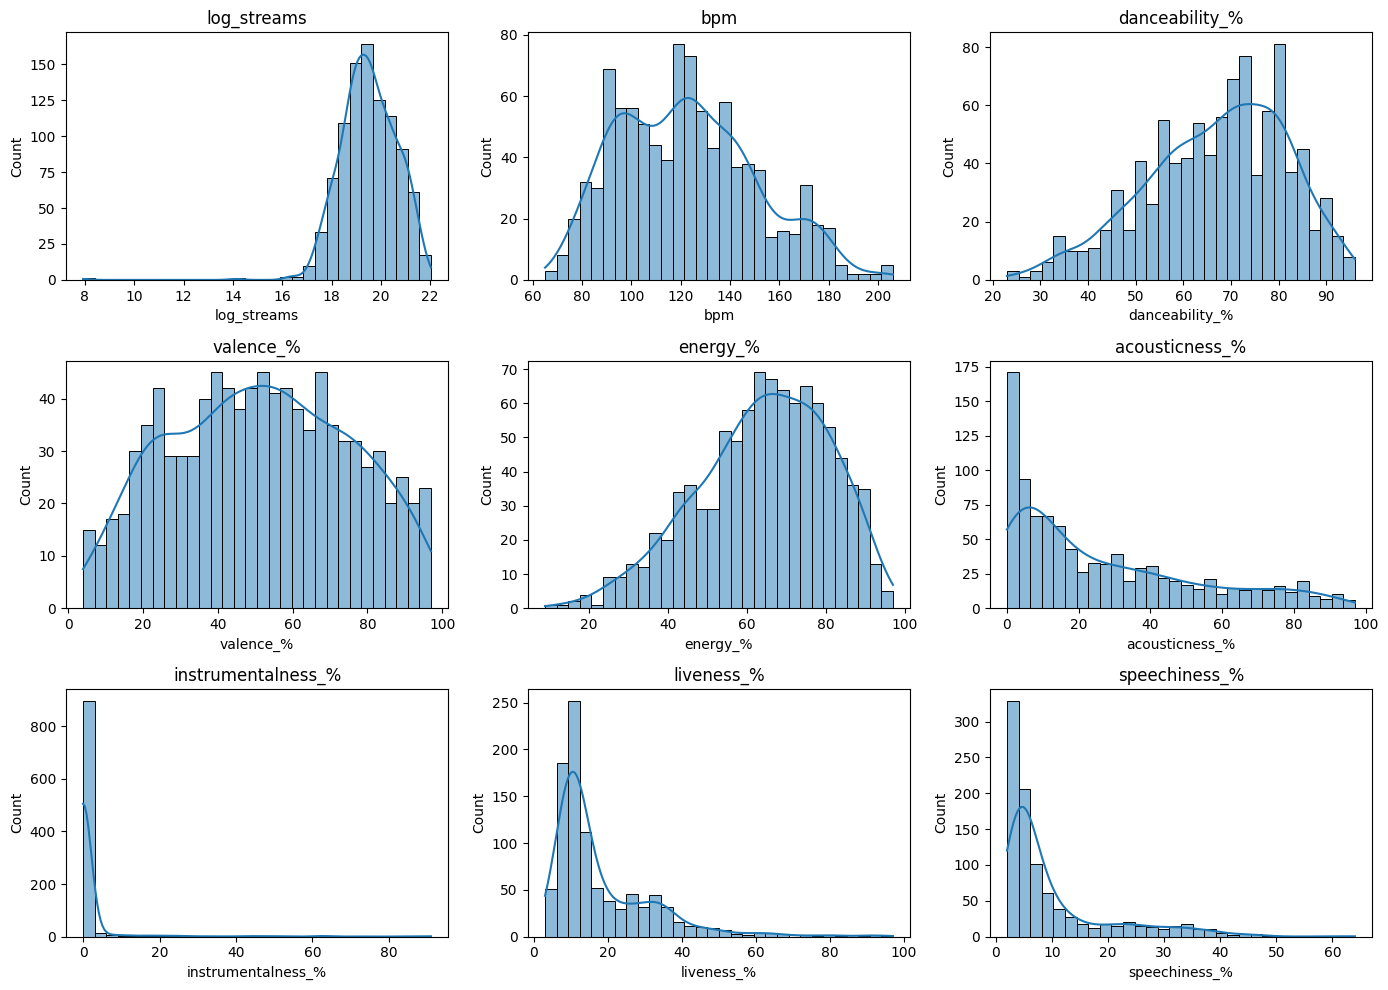

In [ ]:


cols_to_plot = [
    "log_streams", "bpm", "danceability_%", "valence_%", "energy_%",
    "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"
]

plt.figure(figsize=(14, 10))

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()


## Correlation heatmap (log_streams vs features)
We compute Pearson correlations between `log_streams` and both audio and exposure features.
This helps us identify which variables are most strongly associated with success.


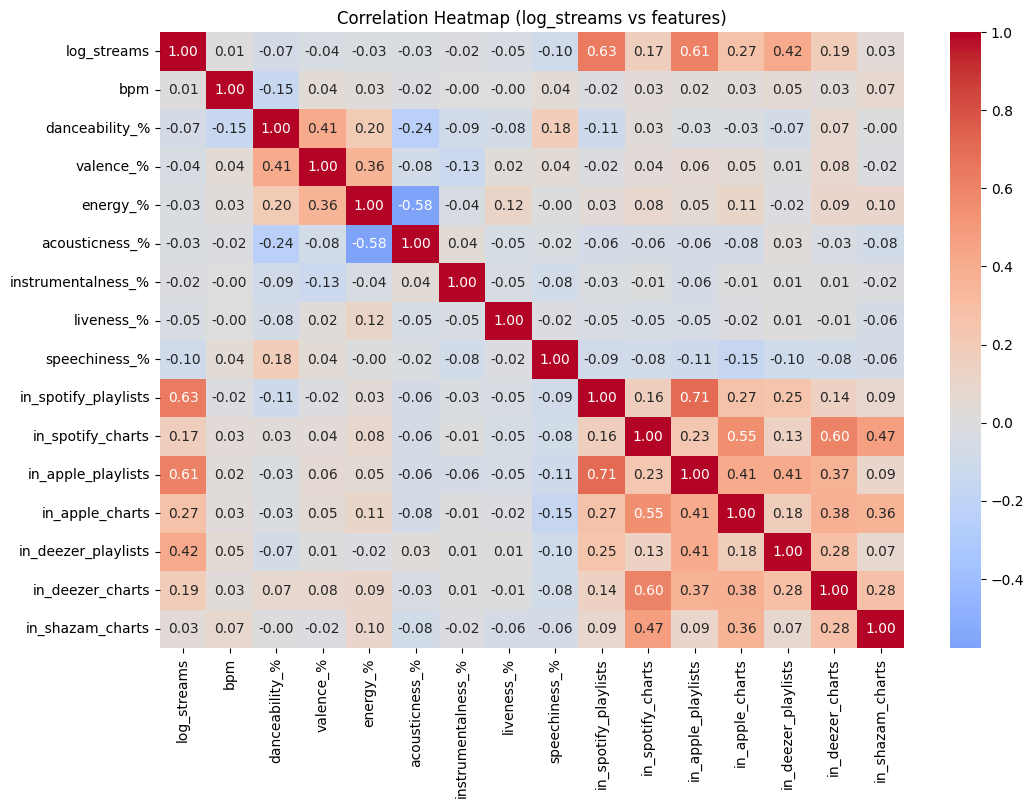

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant numeric features
corr_features = [
    "log_streams", "bpm", "danceability_%", "valence_%", "energy_%",
    "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%",
    "in_spotify_playlists", "in_spotify_charts",
    "in_apple_playlists", "in_apple_charts",
    "in_deezer_playlists", "in_deezer_charts",
    "in_shazam_charts"
]

# Compute correlations
corr = df[corr_features].corr(method="pearson")

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (log_streams vs features)")
plt.show()


## Scatterplots: log_streams vs playlists exposure
We test the relationship between streams and playlist exposure (Spotify, Apple, Deezer).
The goal is to:
- confirm linear association,
- detect potential outliers (songs with high streams but low playlist presence),
- provide a business insight: playlist inclusion is a strong driver of track success.


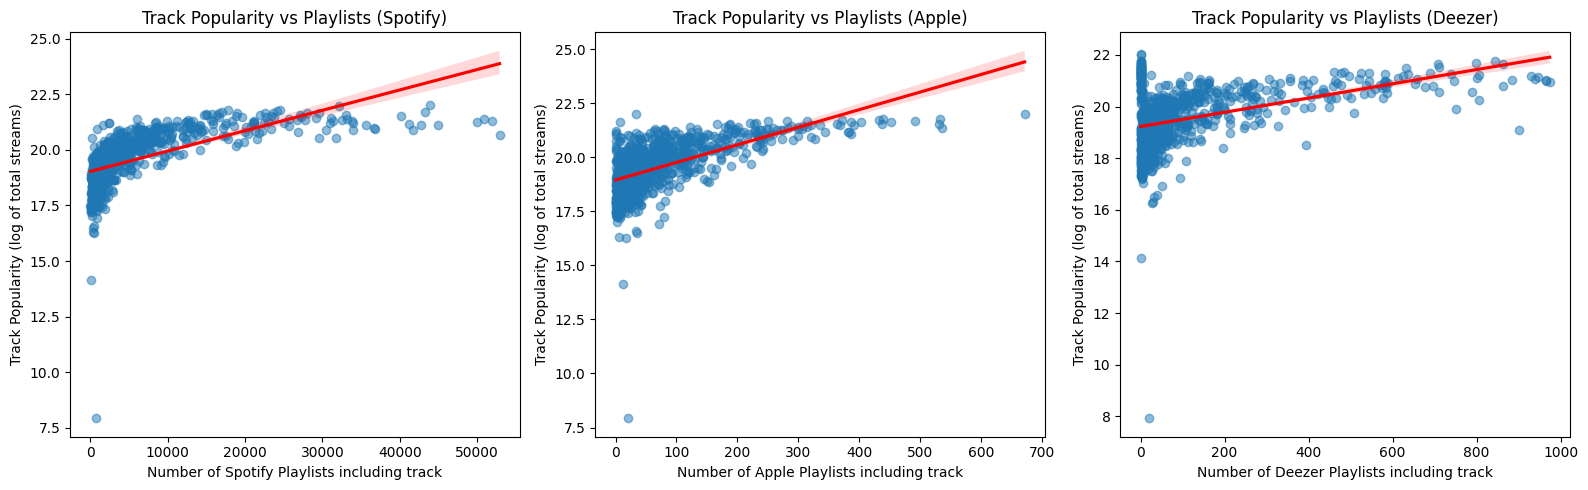

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

playlist_features = [
    ("in_spotify_playlists", "Number of Spotify Playlists including track"),
    ("in_apple_playlists", "Number of Apple Playlists including track"),
    ("in_deezer_playlists", "Number of Deezer Playlists including track")
]

plt.figure(figsize=(16, 5))

for i, (col, xlabel) in enumerate(playlist_features, 1):
    plt.subplot(1, 3, i)
    sns.regplot(
        x=df[col], 
        y=df["log_streams"], 
        scatter_kws={"alpha":0.5}, 
        line_kws={"color":"red"}
    )
    plt.xlabel(xlabel)
    plt.ylabel("Track Popularity (log of total streams)")
    plt.title(f"Track Popularity vs Playlists ({xlabel.split()[2]})")

plt.tight_layout()
plt.show()


## Business Insights — Playlist exposure
- **Spotify playlists** show the strongest link with track popularity. Being included in more playlists is directly associated with higher streams.
- **Apple playlists** follow a similar trend, though on a smaller scale.
- **Deezer playlists** have a weaker impact, suggesting the platform plays a smaller role in driving massive streams.
- **Outliers**: some tracks achieve high popularity with relatively few playlists, indicating viral or organic success outside traditional playlist mechanisms.

 **Takeaway**: Playlist exposure is a primary business driver of track success, confirming that distribution strategies (playlist placement) are as critical as the song’s intrinsic features.


## Scatterplots: log_streams vs audio features
We check how musical characteristics relate to track popularity.
Focus on:
- Danceability (%)
- Energy (%)
- Acousticness (%)
- Speechiness (%)


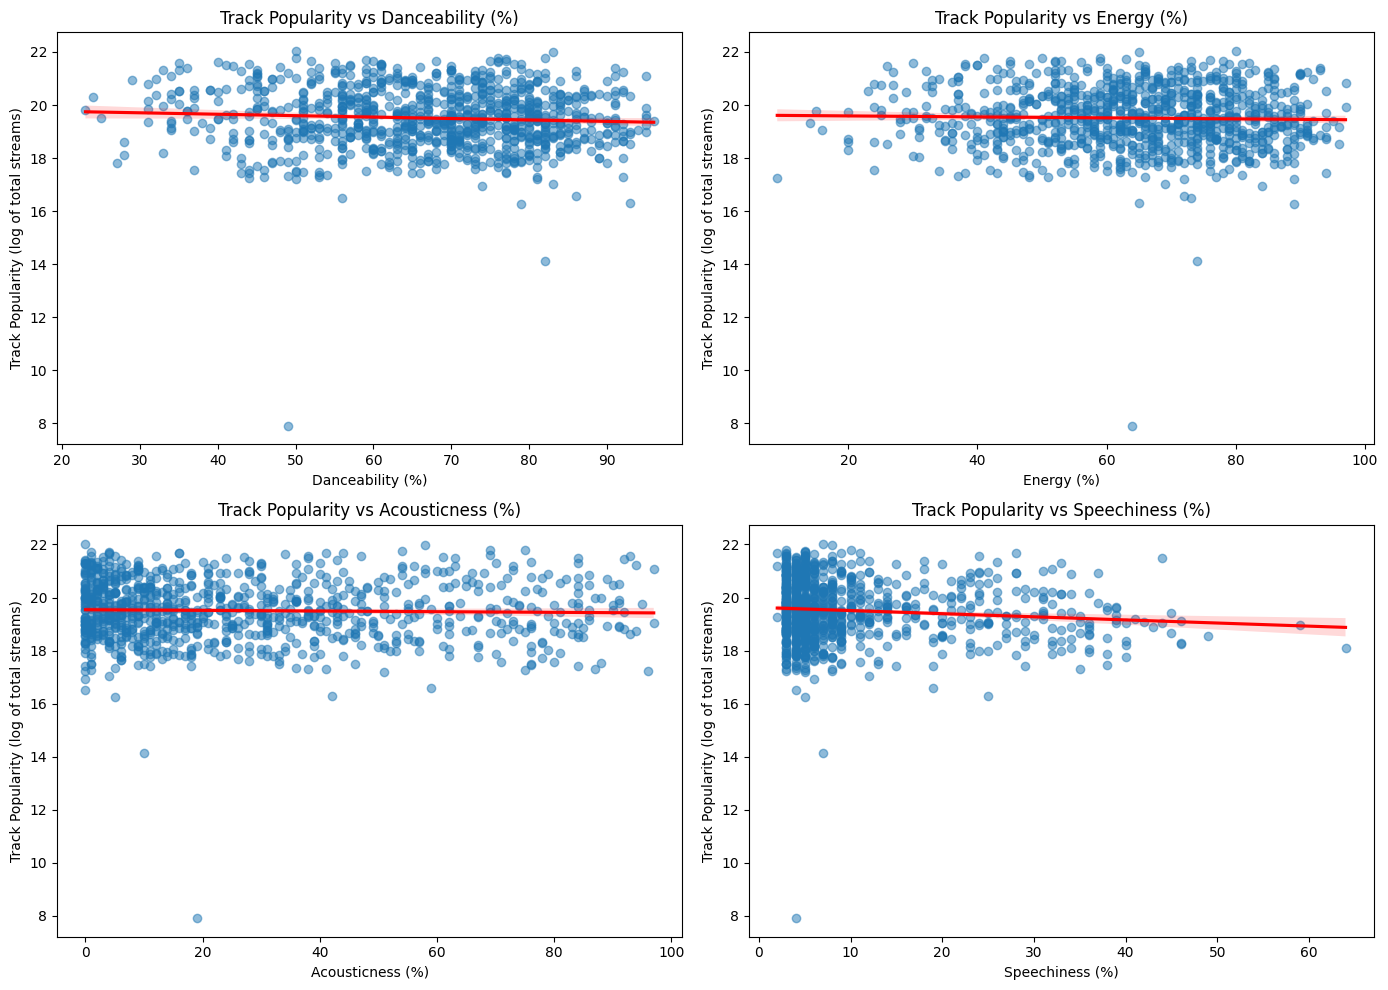

In [ ]:
audio_features = [
    ("danceability_%", "Danceability (%)"),
    ("energy_%", "Energy (%)"),
    ("acousticness_%", "Acousticness (%)"),
    ("speechiness_%", "Speechiness (%)")
]

plt.figure(figsize=(14, 10))

for i, (col, xlabel) in enumerate(audio_features, 1):
    plt.subplot(2, 2, i)
    sns.regplot(
        x=df[col],
        y=df["log_streams"],
        scatter_kws={"alpha":0.5},
        line_kws={"color":"red"}
    )
    plt.xlabel(xlabel)
    plt.ylabel("Track Popularity (log of total streams)")
    plt.title(f"Track Popularity vs {xlabel}")

plt.tight_layout()
plt.show()


## Business Insights — Audio Features
- **Danceability, Energy, Acousticness** show weak or no direct correlation with track popularity. 
  - Most successful tracks cluster in mid-to-high values of danceability and energy, but the effect is not linear.
- **Speechiness** presents a small negative correlation: tracks with higher spoken content (e.g., rap/spoken word) tend to accumulate fewer streams compared to pop/dance hits.
- Overall, **audio features alone are weak predictors of success** compared to playlist exposure, but they can still help differentiate between genres or niche trends.

**Takeaway**: Musical characteristics provide context but are secondary drivers. Playlist placement remains the main determinant of streaming success.


## Correlation summary
We highlight the strongest positive and negative correlations with log_streams.
This helps prioritize features for further modeling.


In [ ]:
# Sort correlations by strength
corr_summary = (
    df.corr(numeric_only=True)["log_streams"]
    .drop("log_streams")
    .sort_values(ascending=False)
)

corr_summary.head(5), corr_summary.tail(5)


(streams                 0.814736
 in_spotify_playlists    0.632161
 in_apple_playlists      0.613879
 in_deezer_playlists     0.418368
 in_apple_charts         0.270380
 Name: log_streams, dtype: float64,
 liveness_%       -0.046521
 danceability_%   -0.068896
 speechiness_%    -0.101585
 artist_count     -0.159049
 released_year    -0.252009
 Name: log_streams, dtype: float64)

## Outlier analysis
We check the top 5 tracks with the highest and lowest stream counts 
to detect exceptional cases (viral hits or underperforming songs).


In [ ]:
# Top 5 most streamed songs
top_tracks = df.sort_values("streams", ascending=False).head(5)[
    ["track_name", "artist(s)_name", "streams", "in_spotify_playlists", "in_apple_playlists"]
]

# Bottom 5 least streamed songs
bottom_tracks = df.sort_values("streams", ascending=True).head(5)[
    ["track_name", "artist(s)_name", "streams", "in_spotify_playlists", "in_apple_playlists"]
]

top_tracks, bottom_tracks


(                                        track_name         artist(s)_name  \
 55                                 Blinding Lights             The Weeknd   
 179                                   Shape of You             Ed Sheeran   
 86                               Someone You Loved          Lewis Capaldi   
 620                                   Dance Monkey            Tones and I   
 41   Sunflower - Spider-Man: Into the Spider-Verse  Post Malone, Swae Lee   
 
           streams  in_spotify_playlists  in_apple_playlists  
 55   3.703895e+09                 43899                 672  
 179  3.562544e+09                 32181                  33  
 86   2.887242e+09                 17836                 440  
 620  2.864792e+09                 24529                 533  
 41   2.808097e+09                 24094                 372  ,
                       track_name  \
 123                  Que Vuelvas   
 393            Jhoome Jo Pathaan   
 144                        QUEMA   
 14

In [ ]:
import pandas as pd
from IPython.display import display, Markdown

# Select relevant columns
cols = ["track_name", "artist(s)_name", "streams", "in_spotify_playlists", "in_apple_playlists"]

# Top 5 and Bottom 5 ordered numerically
top_tracks = df.sort_values("streams", ascending=False).head(5)[cols].copy()
bottom_tracks = df.sort_values("streams", ascending=True).head(5)[cols].copy()

# Formatters
def format_streams(x):
    if x >= 1e9:
        return f"{x/1e9:.2f} B"
    elif x >= 1e6:
        return f"{x/1e6:.2f} M"
    elif x >= 1e3:
        return f"{x/1e3:.0f} K"
    else:
        return str(int(x))

# Apply formatting
top_tracks["num_of_stream"] = top_tracks["streams"].apply(format_streams)
bottom_tracks["num_of_stream"] = bottom_tracks["streams"].apply(format_streams)

# Reorder columns
cols_final = ["track_name", "artist(s)_name", "num_of_stream", "in_spotify_playlists", "in_apple_playlists"]

# Display with clear headers
display(Markdown("### Top 5 Most Streamed Tracks"))
display(top_tracks[cols_final])

display(Markdown("### Bottom 5 Least Streamed Tracks"))
display(bottom_tracks[cols_final])


### Top 5 Most Streamed Tracks

,track_name,artist(s)_name,num_of_stream,in_spotify_playlists,in_apple_playlists
55,Blinding Lights,The Weeknd,3.70 B,43899,672
179,Shape of You,Ed Sheeran,3.56 B,32181,33
86,Someone You Loved,Lewis Capaldi,2.89 B,17836,440
620,Dance Monkey,Tones and I,2.86 B,24529,533
41,Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",2.81 B,24094,372


### Bottom 5 Least Streamed Tracks

,track_name,artist(s)_name,num_of_stream,in_spotify_playlists,in_apple_playlists
123,Que Vuelvas,"Carin Leon, Grupo Frontera",3 K,763,21
393,Jhoome Jo Pathaan,"Arijit Singh, Vishal Dadlani, Sukriti Kakar, V...",1.37 M,138,13
144,QUEMA,"Sog, Ryan Castro, Peso Pluma",11.60 M,437,17
142,"Gol Bolinha, Gol Quadrado 2","Mc Pedrinho, DJ 900",11.96 M,293,5
68,Overdrive,Post Malone,14.78 M,410,36
